In [6]:
from rdkit import Chem
from rdkit.Chem import Draw
import matplotlib.pyplot as plt

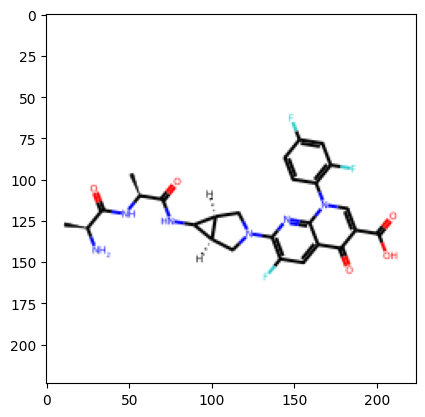

In [12]:
# Load sucrose from SMILES
smile_example = "C[C@@H](C(=O)N[C@@H](C)C(=O)NC1[C@H]2[C@@H]1CN(C2)C3=C(C=C4C(=O)C(=CN(C4=N3)C5=C(C=C(C=C5)F)F)C(=O)O)F)N"
mol = Chem.MolFromSmiles(smile_example)

# Draw 3D structure
img = Draw.MolToImage(mol, size=(224, 224))
plt.imshow(img)

# Save image
img.save("data_smiles/sucrose.png")

O=C(O)c1cn(-c2ccc(F)cc2F)c2c(cc(F)c(N3C[C@@H]4C(NC([C@H](C)NC(=O)[C@@H](N)C)=O)[C@@H]4C3)n2)c1=O
c1(F)cc(F)ccc1-n1c2c(c(=O)c(C(=O)O)c1)cc(F)c(N1C[C@H]3C(NC(=O)[C@@H](NC([C@@H](N)C)=O)C)[C@H]3C1)n2
O=C(NC1[C@@H]2CN(c3c(F)cc4c(=O)c(C(=O)O)cn(-c5c(F)cc(F)cc5)c4n3)C[C@H]12)[C@@H](NC(=O)[C@H](C)N)C
c1(=O)c(C(=O)O)cn(-c2ccc(F)cc2F)c2nc(N3C[C@@H]4[C@@H](C4NC([C@H](C)NC(=O)[C@H](C)N)=O)C3)c(F)cc12
c1cc(F)cc(F)c1-n1cc(C(=O)O)c(=O)c2c1nc(N1C[C@H]3C(NC([C@@H](NC([C@@H](N)C)=O)C)=O)[C@H]3C1)c(F)c2


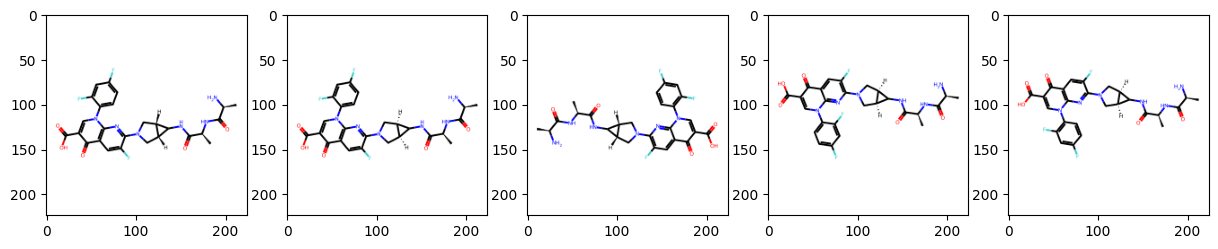

In [13]:
# data augmentation
from data_smiles.SmilesEnumeration import SmilesEnumerator

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
sme = SmilesEnumerator()
for i in range(5):
    example_randomized = sme.randomize_smiles(smile_example)
    print(example_randomized)

    mol = Chem.MolFromSmiles(example_randomized)

    # Draw 3D structure
    img = Draw.MolToImage(mol, size=(224, 224))
    axes[i].imshow(img)

# Generate images

In [17]:
# load training data
import pandas as pd

pd_data_train = pd.read_csv("data_smiles/Training_Group.csv")
print(pd_data_train.shape)
pd_data_train.head()

(1241, 2)


,Smiles,Liver
0,S=C=Nc1c2c(ccc1)cccc2,Hepatotoxicity
1,c1(c(cc(cc1[N+](=O)[O-])[N+](=O)[O-])[N+](=O)[...,Hepatotoxicity
2,c1(c(cc(cc1)[N+](=O)[O-])[N+](=O)[O-])O,Hepatotoxicity
3,O(CCO)CC,Hepatotoxicity
4,Oc1cc2c(cc1)cccc2,Hepatotoxicity


In [29]:
pd_data_test = pd.read_csv("data_smiles/Testing_Group.csv")
print(pd_data_test.shape)
pd_data_test.head()

(286, 2)


,Smiles,Liver
0,C[C@@H](C(=O)N[C@@H](C)C(=O)NC1[C@H]2[C@@H]1CN...,Hepatotoxicity
1,C=CCOC1=C(C=C(C=C1)CC(=O)O)Cl,Hepatotoxicity
2,CCCN(CCC)C(=O)CC1=C(N=C2N1C=C(C=C2)Cl)C3=CC=C(...,Hepatotoxicity
3,C1CC2=CC=CC=C2C(C3=CC=CC=C31)NCCCCCCC(=O)O,Hepatotoxicity
4,C1=CC=C(C=C1)CN2C3=CC=CC=C3C(=N2)OCC(=O)O,Hepatotoxicity


In [28]:
# save SMILES images from training data
sme = SmilesEnumerator()
for i, row in pd_data_train.iterrows():
    smile = row["Smiles"]
    # using positive hash
    smile_normalized = str(hash(smile) % ((1 << 31) - 1))

    mol = Chem.MolFromSmiles(smile)
    img = Draw.MolToImage(mol, size=(224, 224))
    img.save(f"data_smiles/Training_Group/{smile_normalized}.png")

    # data augmentation
    for j in range(5):
        example_randomized = sme.randomize_smiles(smile)
        mol = Chem.MolFromSmiles(example_randomized)
        img = Draw.MolToImage(mol, size=(224, 224))
        img.save(f"data_smiles/Training_Group_Augmented/{smile_normalized}_{j}.png")


In [31]:
# save SMILES images from Testing data
sme = SmilesEnumerator()
for i, row in pd_data_test.iterrows():
    smile = row["Smiles"]
    # using positive hash
    smile_normalized = str(hash(smile) % ((1 << 31) - 1))

    mol = Chem.MolFromSmiles(smile)
    img = Draw.MolToImage(mol, size=(224, 224))
    img.save(f"data_smiles/Testing_Group/{smile_normalized}.png")
